# Project 4

Main Objectives:

1. Determine the industry factors that are most important in predicting the salary amounts for these data.
2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle
import seaborn as sns
% matplotlib inline

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from time import sleep
from bs4 import BeautifulSoup
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, Lars, BayesianRidge, RidgeCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## Data Collection 
Collect data from Indeed.com on data-related jobs to use in predicting salary trends for your analysis.
Select and parse data from at least 1000 postings for jobs, potentially from multiple location searches.

#### Approach:
First search the list of jobs that we are interested in, collect the following fields:

- job title
- company name
- location
- link to job description

Then go through each link collected, extract job description

In [2]:
class ExtractListings(object):
    '''extract information from listing'''
    
    
    def __init__(self):
        self.job_titles_ = []
        self.companies_ = []
        self.locations_ = []
        self.links_ = []
        self.df_= pd.DataFrame()
    
    def extract_listings(self, source):
        '''extracts info from source passed, excluding job description'''
        page = BeautifulSoup(source, 'html.parser')
        
        # get all job listings
        listings = page.find_all('div', attrs={'class':'row'})
#         listings += page.find_all('div', attrs={'class':'row sjlast result clickcard'})
        
        for listing in listings:
            
            try:
                # compile job titles
                title = [listing.a.get('title').strip()]

                # company
                company = [listing.find('span', attrs={'class':'company'}).text.strip()]

                # location
                location = [listing.find('span', attrs={'class':'location'}).text.strip()]

                # link
                link = [listing.a.get('href').strip()]
                
            except: continue
        
            # update running lists
            self.job_titles_ += title
            self.companies_ += company
            self.locations_ += location
            self.links_ += link
        
        # check that all the lists are the same length
        assert len(self.job_titles_) == len(self.companies_) == len(self.locations_) == len(self.links_)
    
      
    def next_page(self, url):
        '''navigates to the next page'''
        
        # change url first
        if '&start=' not in url:
            new_url = url + '&start=10'
        else:
            url_base, num = url.split('&start=')
            num = str(int(num)+10)
            new_url = url_base + '&start=' + num
        
        # navigate to new page
        driver.get(new_url)
        sleep(1)
        source = driver.page_source
        return new_url, source
        

    def update_save(self):
        '''updates master df with latest df'''
                
        # compile in df
        self.df_ = pd.DataFrame({'title': self.job_titles_, 
                         'company': self.companies_,
                         'location': self.locations_, 
                         'link': self.links_, })
        # drop dups
        self.df_.drop_duplicates(inplace=True)
        
        # save in pickle file
        pickle.dump(self.df_, open('listings.p', 'wb'))

        

In [17]:
class PullDesc(object):
    '''extract job description from listing'''
    
    
    def __init__(self):
        self.links_ = []
        self.desc_ = []
        self.flag_ = []
        
        
    def _pull_set_desc(self, links):
        '''from list of links, extract descriptions'''
        self.links_ += links
        driver = webdriver.Chrome(executable_path='./chromedriver/chromedriver.exe')
        wait = WebDriverWait(driver, 10)
        driver.set_page_load_timeout(15)

        for i, link in enumerate(links):
            
            try:
                driver.get('https://www.indeed.com.sg'+link)
                sleep(1)
                source = driver.page_source
                soup = BeautifulSoup(source, 'html.parser')
                
                # remove the rubbish text
                tags_to_exclude = ['footer', 'header', 'style', 'script', 'noscript', 'option', 'input', 
                                   'nav', 'aside', 'blockquote']
                for tag in tags_to_exclude:
                    for item in soup.find_all(tag):
                        item.decompose()

                # check for errors
                text = soup.body.text.strip()
                assert 'ERR_NAME_RESOLUTION_FAILED' not in text
                
                tc = text.encode('utf-8').lower()
                if ('skill' not in tc) and ('role' not in tc) and ('qualification' not in tc) \
                and ('job description' not in tc) and ('responsibilities' not in tc) and ('experience' not in tc):
                    self.flag_.append(1)
                else: self.flag_.append(0)
                    
                self.desc_.append(text)
                
            except:
                self.desc_.append('NA')
                self.flag_.append(1)
                driver.close()
                driver = webdriver.Chrome(executable_path='./chromedriver/chromedriver.exe')
                wait = WebDriverWait(driver, 10)
                
            print i,
                
        assert len(self.links_) == len(self.desc_)
        driver.close()
    
    
    def update_save(self):
        '''save into pickle'''
        
        df = pd.DataFrame({'link': self.links_,
                               'description': self.desc_,
                               'flag': self.flag_})
        
        # drop dups
        df.drop_duplicates(inplace=True)
        
        # save in pickle file
        pickle.dump(df, open('descriptions.p', 'wb'))
        
        
    def pull_desc(self, df, num=50):
        '''master function: gets the job descriptions for entire df of listings'''
        
        all_links = df['link'].tolist()
        print 'Loading {} sites'.format(len(all_links))
        
        # group links
        for ind in range(0,len(all_links), num):
            if ind+num < len(all_links):
                grp_links = all_links[ind:ind+num]
            else:
                grp_links = all_links[ind::]
        
            # extract descriptions
            print 'start', ind, ':', 
            self._pull_set_desc(grp_links)
            self.update_save()
            print 'saved'

In [4]:
# make list of the various job titles to search through:
job_search_list = ['data scientist', 'data analyst', 'data engineer', 'business intelligence']
pages = 70

In [5]:
# load the selenium Chrome driver
driver = webdriver.Chrome(executable_path='./chromedriver/chromedriver.exe')
wait = WebDriverWait(driver, 10)
extract = ExtractListings()

# search through each job in search list
for job in job_search_list:
    print job.upper() + ':',
    
    # open indeed
    driver.get('https://www.indeed.com.sg')
    sleep(1)
    
    # enter in search field
    try:
        element = driver.find_element_by_id('what')
    except:
        element = driver.find_element_by_id('text-input-what')
    element.send_keys(job)
    element.submit()
    
    # load current page
    source = driver.page_source
    url = driver.current_url.encode()
    
    # loop through specified number of pages of links
    for page in range(pages):
        
        # extract info
        df = extract.extract_listings(source)
        extract.update_save()
        
        print page,

        # move on to next page
        url, source = extract.next_page(url)
    
    print 'done'
    
driver.close()

DATA SCIENTIST: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 done
DATA ANALYST: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 done
DATA ENGINEER: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 done
BUSINESS INTELLIGENCE: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 done


In [18]:
# dataframe of listings (no descriptors)
df = pickle.load(open('listings.p', 'rb'))
print df.shape
df.head()

(2319, 4)


,company,link,location,title
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...


In [19]:
# start pulling descriptors
pull = PullDesc()
pull.pull_desc(df)

Loading 2319 sites
start 0 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 50 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 100 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 150 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 200 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 250 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 saved
start 300 : 0 1 2 3 4 5 6 7 8 9 10 1

In [20]:
# load descriptors
descs = pickle.load(open('descriptions.p', 'rb'))
# descs.shape[0] - descs.flag.sum()
descs

,description,flag,link
0,Go to the main content section.MerckMenu\n ...,0,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...
1,?\n\nHomeSearch openingsSearch resultsCurren...,0,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...
2,"Skip to Job Description, SearchClose\n\n\n\n\n...",0,/company/Pan-Asia-Group/jobs/Data-Scientist-44...
3,Go to the main content section.Procter & Gambl...,0,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...
4,Go to the main content section.Procter & Gambl...,0,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...
5,We are Grabbing the job detail for you\n \nGet...,1,/rc/clk?jk=1194d1b9e81b8d35&fccid=b79fa3ee1865...
6,Skip to Content,1,/rc/clk?jk=eb9ce6b9d94f1415&fccid=fe2d21eef233...
7,All jobs\n→\nData Scientist\n\nData Scientist\...,0,/rc/clk?jk=95a6064e4ea39071&fccid=0b476c4a7add...
8,Go to the main content section.PersonalBusines...,0,/rc/clk?jk=f3540a98038207b3&fccid=6f4d576f7f43...
9,24\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n \n...,0,/rc/clk?jk=aad0e9e7b555c02c&fccid=e1551976d481...


In [52]:
# combine into 1 dataframe
data = pd.concat([df, descs.drop('link', axis=1)], axis=1)
data

,company,link,location,title,description,flag
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist,Go to the main content section.MerckMenu\n ...,0.0
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist,?\n\nHomeSearch openingsSearch resultsCurren...,0.0
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist,"Skip to Job Description, SearchClose\n\n\n\n\n...",0.0
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...,Go to the main content section.Procter & Gambl...,0.0
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...,Go to the main content section.Procter & Gambl...,0.0
5,Grab Taxi,/rc/clk?jk=1194d1b9e81b8d35&fccid=b79fa3ee1865...,Singapore,Data Scientist (Machine Learning),We are Grabbing the job detail for you\n \nGet...,1.0
6,Amazon.com,/rc/clk?jk=eb9ce6b9d94f1415&fccid=fe2d21eef233...,Singapore,Business Analyst -- HR Analytics,Skip to Content,1.0
7,Shopee,/rc/clk?jk=95a6064e4ea39071&fccid=0b476c4a7add...,Singapore,Data Scientist,All jobs\n→\nData Scientist\n\nData Scientist\...,0.0
8,StarHub,/rc/clk?jk=f3540a98038207b3&fccid=6f4d576f7f43...,Singapore,Data Analyst / Scientist,Go to the main content section.PersonalBusines...,0.0
9,Taiger,/rc/clk?jk=aad0e9e7b555c02c&fccid=e1551976d481...,Singapore,Data Scientist,24\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n \n...,0.0


In [53]:
# drop the missing values
print data.isnull().sum()

data.dropna(inplace=True)
data.shape

company        327
link           327
location       327
title          327
description    327
flag           327
dtype: int64


(1992, 6)

In [54]:
# since we have a good number of entries left, drop rows where flag = 1 (poor data quality)
data = data[data.flag == 0].drop('flag', axis=1)
data.shape

(1783, 5)

In [55]:
# ignore link, drop duplicates
data.drop_duplicates(subset=['company', 'location', 'title', 'description'], inplace=True)

# reset index
data.reset_index(inplace=True, drop=True)

print data.shape
data.head() 


(1759, 5)


,company,link,location,title,description
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist,Go to the main content section.MerckMenu\n ...
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist,?\n\nHomeSearch openingsSearch resultsCurren...
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist,"Skip to Job Description, SearchClose\n\n\n\n\n..."
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...,Go to the main content section.Procter & Gambl...
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...,Go to the main content section.Procter & Gambl...


In [56]:
# manually delete first few lines from entry 1617 cos it is strangely problematic
data.description[1617] = data.description[1617][700:]

In [58]:
# pickle
pickle.dump(data, open('data.p', 'wb'))

print data.shape

(1759, 5)


### Extract salary from description

In [59]:
# load from pickle
data = pickle.load(open('data.p', 'rb'))
print data.shape

(1759, 5)


In [60]:
# cut out the parts that may be relevant to salary, including some other text for context
snippets = []
# take a look at the salary data available
for i, desc in enumerate(data.description):
    desc = desc.encode('utf-8')
    snippet = ''
    
    # find SGD
    find= re.search(u'..............(SGD[0-9 ,.SGDkKto–])+..................', desc)
    if find !=None:
        print i, 'v1', find.group()
        snippet = find.group()
        
    # find $
    find = re.search(u'..............\$[kKto0-9 ,.\$-]+..................', desc)
    if find !=None:
        print i, 'v2', find.group()
        snippet = find.group()
        
    find = re.search(ur'..............(\$[0-9 ,\$kKto-]+)[/A-Za-z"-]+..................', desc)
    if find !=None:
        print i, 'v3', find.group()
        snippet = find.group()
        
    # append 
    snippets.append(snippet)
    

2 v2               $5,000 - $8,500 a month - 
2 v3               $5,000 - $8,500 a month - 
43 v2               $3,500 - $7,000 a month
79 v2               $36,000 - $72,000 a year
80 v2  We generated $16.9B in revenue last 
81 v2  We generated $16.9B in revenue last 
85 v2      Salary: S$5000.00 - S$8000.00 per annu
91 v2  We generated $16.9B in revenue last 
92 v2  We generated $16.9B in revenue last 
102 v2               $2,500 - $4,000 a month
133 v2 S$80000.00 - S$140000.00 per annum
153 v2  allowance of $3,040.Expected course st
163 v2 31069Salary: S$200000 - S$280000.00 per an
163 v3 31069Salary: S$200000 - S$280000.00 per ann
174 v2 sed more than $100m, are worth more 
174 v3 sed more than $100m, are worth more t
185 v2  We generated $16.9B in revenue last 
186 v2  We generated $16.9B in revenue last 
191 v2  We generated $16.9B in revenue last 
192 v2  We generated $16.9B in revenue last 
200 v2 h revenues of $18 billion and the la
200 v3 h revenues of $18 billion and the larg

1588 v3 ent budget of $7B in 2018, we conti
1590 v2  company with $14.5 billion in sales a
1603 v2 s. ofo raised $700 million in its Ser
1603 v3 s. ofo raised $700 million in its Series E f
1611 v2 ntract, up to $2,500/month)-SingaporeC
1611 v3 ntract, up to $2,500/month)-SingaporeContrac
1631 v2 d SalaryUp to $87,000 annual packageExpe
1631 v3 d SalaryUp to $87,000 annual packageExperience
1637 v2 e Group had US$121.7 billion in consoli
1638 v2               $4,000 - $7,000 a month
1638 v3 ies: Salary: S$4K - S$7K per monthLocat
1642 v2 ith assets of $2 trillion and operat
1642 v3 ith assets of $2 trillion and operations in
1655 v2               $6,000 - $10,000 a month
1659 v2 ent budget of $7B in 2018, we cont
1659 v3 ent budget of $7B in 2018, we conti
1665 v2               $2,000 - $3,000 a month
1672 v2 e Group had US$121.7 billion in consoli
1685 v2 ntractSalary: $7,000.00 /monthRequired edu
1688 v2 se and manage $20 trillion and growin
1688 v3 se and manage $20 trillion and gro

In [61]:
# clean up all the revenue stuff
terms = ['revenue', 'million', 'billion', 'trillion', 'B']
for term in terms:
    snippets = ['' if term in snippet else snippet for snippet in snippets]
len(snippets) # check that we didn't accidentally cut something out

1759

In [62]:
pd.Series([0 if snippet == '' else 1 for snippet in snippets]).sum()
# there are so few entries in the entire dataset that have salary info!!! why so lousy!?

159L

In [63]:
# onerow = snippets[2] #.split()
# print onerow
all_s = []
for i, onerow in enumerate(snippets):
    
    # extract the numerical info from the string
    find = re.findall(r'[\d,.]+', onerow)
    s_both = []
    
    for f in find:

#         print i, f
        # convert to float
        try:
            s = float(f.replace(',', ''))
        
            # remove all the weird values
            if s % 10 == 0:
    #             s_both.append(s)

                # convert annual salaries to monthly
                if s > 50000: 
#                     print s, '!!!!!!!!'
                    s = s / 12.
                    print s, '!!!!!!!!'
                    s_both.append(s)
                else:
                    s_both.append(s)
    #         print s
        
        except:
            pass
        
    if s_both == []:
        s_both = [np.nan, np.nan, np.nan]
    elif len(s_both) == 1:
        s_both.append(np.nan)
        s_both.append(s_both[0])
    elif len(s_both) == 2:
        s_both.append((s_both[0] + s_both[1])/2.)
    assert len(s_both) == 3
    print i, s_both
    all_s.append(s_both)
salary = pd.DataFrame(all_s, columns=['salary_1', 'salary_2', 'salary_av'])


0 [nan, nan, nan]
1 [nan, nan, nan]
2 [5000.0, 8500.0, 6750.0]
3 [nan, nan, nan]
4 [nan, nan, nan]
5 [nan, nan, nan]
6 [nan, nan, nan]
7 [nan, nan, nan]
8 [nan, nan, nan]
9 [nan, nan, nan]
10 [nan, nan, nan]
11 [nan, nan, nan]
12 [nan, nan, nan]
13 [nan, nan, nan]
14 [nan, nan, nan]
15 [nan, nan, nan]
16 [nan, nan, nan]
17 [nan, nan, nan]
18 [nan, nan, nan]
19 [nan, nan, nan]
20 [nan, nan, nan]
21 [nan, nan, nan]
22 [nan, nan, nan]
23 [nan, nan, nan]
24 [nan, nan, nan]
25 [nan, nan, nan]
26 [nan, nan, nan]
27 [nan, nan, nan]
28 [nan, nan, nan]
29 [nan, nan, nan]
30 [nan, nan, nan]
31 [nan, nan, nan]
32 [nan, nan, nan]
33 [nan, nan, nan]
34 [nan, nan, nan]
35 [nan, nan, nan]
36 [nan, nan, nan]
37 [nan, nan, nan]
38 [nan, nan, nan]
39 [nan, nan, nan]
40 [nan, nan, nan]
41 [nan, nan, nan]
42 [nan, nan, nan]
43 [3500.0, 7000.0, 5250.0]
44 [nan, nan, nan]
45 [nan, nan, nan]
46 [nan, nan, nan]
47 [nan, nan, nan]
48 [nan, nan, nan]
49 [nan, nan, nan]
50 [nan, nan, nan]
51 [nan, nan, nan]
52 [

689 [nan, nan, nan]
690 [nan, nan, nan]
691 [nan, nan, nan]
692 [nan, nan, nan]
693 [nan, nan, nan]
694 [5000.0, 6500.0, 5750.0]
695 [nan, nan, nan]
696 [nan, nan, nan]
697 [nan, nan, nan]
698 [nan, nan, nan]
699 [nan, nan, nan]
700 [nan, nan, nan]
701 [nan, nan, nan]
702 [2000.0, 3000.0, 2500.0]
703 [nan, nan, nan]
704 [nan, nan, nan]
705 [nan, nan, nan]
706 [nan, nan, nan]
707 [nan, nan, nan]
708 [nan, nan, nan]
709 [nan, nan, nan]
710 [nan, nan, nan]
711 [nan, nan, nan]
712 [nan, nan, nan]
713 [nan, nan, nan]
714 [nan, nan, nan]
715 [nan, nan, nan]
716 [nan, nan, nan]
717 [nan, nan, nan]
718 [nan, nan, nan]
719 [nan, nan, nan]
720 [nan, nan, nan]
721 [nan, nan, nan]
722 [nan, nan, nan]
723 [nan, nan, nan]
724 [nan, nan, nan]
725 [2400.0, 3000.0, 2700.0]
726 [nan, nan, nan]
727 [nan, nan, nan]
728 [nan, nan, nan]
729 [nan, nan, nan]
730 [nan, nan, nan]
731 [nan, nan, nan]
732 [nan, nan, nan]
733 [nan, nan, nan]
734 [nan, nan, nan]
735 [nan, nan, nan]
736 [nan, nan, nan]
737 [nan, nan

In [64]:
# concat to main dataframe
data = pd.concat([data, salary], axis=1)
data

,company,link,location,title,description,salary_1,salary_2,salary_av
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist,Go to the main content section.MerckMenu\n ...,NaN,NaN,NaN
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist,?\n\nHomeSearch openingsSearch resultsCurren...,NaN,NaN,NaN
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist,"Skip to Job Description, SearchClose\n\n\n\n\n...",5000.0,8500.0,6750.0
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN
5,Shopee,/rc/clk?jk=95a6064e4ea39071&fccid=0b476c4a7add...,Singapore,Data Scientist,All jobs\n→\nData Scientist\n\nData Scientist\...,NaN,NaN,NaN
6,StarHub,/rc/clk?jk=f3540a98038207b3&fccid=6f4d576f7f43...,Singapore,Data Analyst / Scientist,Go to the main content section.PersonalBusines...,NaN,NaN,NaN
7,Taiger,/rc/clk?jk=aad0e9e7b555c02c&fccid=e1551976d481...,Singapore,Data Scientist,24\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n \n...,NaN,NaN,NaN
8,Uber,/rc/clk?jk=be3fefb2b150b502&fccid=f766f8bfbc3e...,Singapore,"Data Analyst, APACx",Skip to main contentTell us your locationCity ...,NaN,NaN,NaN
9,SAP,/rc/clk?jk=58297c05655f8c31&fccid=156c7820d198...,Singapore,"Machine Learning / Deep Learning Developer , S...",Close\n\n By continuing to ...,NaN,NaN,NaN


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 8 columns):
company        1759 non-null object
link           1759 non-null object
location       1759 non-null object
title          1759 non-null object
description    1759 non-null object
salary_1       151 non-null float64
salary_2       135 non-null float64
salary_av      151 non-null float64
dtypes: float64(3), object(5)
memory usage: 110.0+ KB


In [66]:
# save as pickle
pickle.dump(data, open('data_salary.p', 'wb'))

## QUESTION 1: Factors that impact salary
To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [2]:
# load from pickle
q1 = pickle.load(open('data_salary.p', 'rb'))
print q1.shape
q1.head()

(1759, 8)


,company,link,location,title,description,salary_1,salary_2,salary_av
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist,Go to the main content section.MerckMenu\n ...,NaN,NaN,NaN
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist,?\n\nHomeSearch openingsSearch resultsCurren...,NaN,NaN,NaN
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist,"Skip to Job Description, SearchClose\n\n\n\n\n...",5000.0,8500.0,6750.0
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN


### Feature Extraction

In [3]:
# try out count vectoriser just to see see
cvec = CountVectorizer(stop_words='english', min_df=1, ngram_range=(2,2))
cvec.fit(q1.title)

df= pd.DataFrame(cvec.transform(q1.title).todense(), columns=cvec.get_feature_names())

print len(df.columns)
df.sum().sort_values(ascending=False)

2440


brunei relocation              111
data scientist                 106
software engineer               93
business analyst                84
data science                    80
science analyst                 65
management ubereats             62
analyst database                62
database management             62
ubereats apac                   62
data analyst                    61
data engineer                   59
project engineer                53
engineer brunei                 49
ios engineer                    45
data analytics                  36
big data                        36
senior analyst                  35
business intelligence           33
senior data                     33
superintendent brunei           31
services superintendent         31
construction services           31
planner brunei                  31
business development            29
operations analyst              24
development manager             22
manager national                21
national government 

In [4]:
# extract features in the title
tfidf = TfidfVectorizer(stop_words='english', min_df=1, ngram_range=(1,3), max_features=1000)
tfidf.fit(q1.title)

df_title= pd.DataFrame(tfidf.transform(q1.title).todense(), columns=['title_'+f for f in tfidf.get_feature_names()])

print len(df_title.columns)
df_title.sum().sort_values(ascending=False)

1000


title_analyst                                136.479692
title_engineer                               128.899936
title_data                                   102.764898
title_business                                59.941073
title_scientist                               53.544505
title_senior                                  46.380817
title_software                                44.415206
title_data scientist                          43.557809
title_software engineer                       39.836451
title_manager                                 37.749935
title_business analyst                        37.068612
title_data analyst                            35.455509
title_brunei relocation                       33.103296
title_brunei                                  33.103296
title_relocation                              33.103296
title_ios                                     30.641528
title_ios engineer                            30.210969
title_analytics                               29

In [5]:
# extract features from description
tfidf = TfidfVectorizer(stop_words='english', min_df=1, ngram_range=(1,3), max_features=1000)
tfidf.fit(q1.description)

df_desc= pd.DataFrame(tfidf.transform(q1.description).todense(), columns=['desc_'+f for f in tfidf.get_feature_names()])

print len(df_desc.columns)
df_desc.sum().sort_values(ascending=False)

1000


desc_job                            148.756916
desc_data                           134.160870
desc_business                       112.908686
desc_experience                      92.497678
desc_singapore                       87.015029
desc_team                            82.001335
desc_apply                           79.109294
desc_work                            71.912920
desc_jobs                            63.763250
desc_management                      63.048376
desc_project                         62.112977
desc_skills                          61.587690
desc_software                        58.147528
desc_development                     58.026633
desc_engineer                        56.531259
desc_support                         56.139252
desc_new                             54.313635
desc_analytics                       52.096910
desc_solutions                       51.828201
desc_ago                             51.402209
desc_email                           50.910741
desc_technolo

In [6]:
# one hot encode the company and location features
df_location = pd.get_dummies(q1.location, drop_first=True, prefix= 'loc')
df_company = pd.get_dummies(q1.company, drop_first=True, prefix= 'com')

In [8]:
# set up X and y matrices
X = pd.concat([df_title, df_desc, df_location, df_company], axis=1)
y = q1.salary_av

test_ind = y.isnull()
X_train = X[~test_ind]
X_test = X[test_ind]
y_train = y[~test_ind]

In [9]:
# standardise X matrix
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

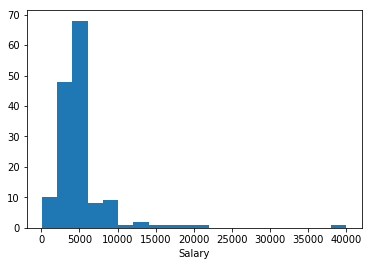

In [10]:
# show distribution of salaries
plt.hist(y_train, bins=20)
plt.xlabel('Salary')
plt.show()

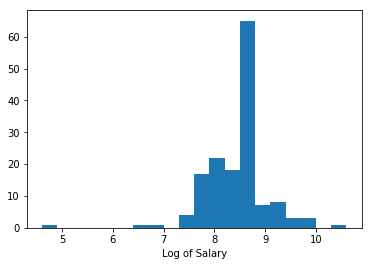

In [11]:
# show distribution of salaries - logged
plt.hist(np.log(y_train), bins=20)
plt.xlabel('Log of Salary')
plt.show()
# the log of salary looks much more normal, use that in model instead.
y_train_log = np.log(y_train)

### Build some models

In [12]:
def cross_val_disp(est, X_train=X_train, y_train=y_train_log, cv=5):
    '''calculate cross_val_score and print result'''
    results = cross_val_score(est, X_train, y_train, cv=cv)
    # print results
    print 'R^2 = {:0.3} +/- {:0.3}'.format(results.mean(), results.std())
    
rs = 40
njobs=3

In [13]:
# try out baseline linear regression
linreg = LinearRegression()
# linreg.fit(X_train, y_train)
cross_val_disp(linreg)
# the R^2 is super shitty - probably cos got so few samples

R^2 = 0.232 +/- 0.264


In [14]:
# try lasso to drop some variables
lasso = LassoCV(cv=5, max_iter=2000, random_state=rs)
cross_val_disp(lasso)

R^2 = 0.264 +/- 0.171


In [15]:
# try more regularisation with ridge
ridge = RidgeCV()
cross_val_disp(ridge)

R^2 = 0.248 +/- 0.244


In [16]:
# SVR
svr = SVR()
svr_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
             'C': np.logspace(-5, 10, 5),
             'epsilon': [0.0001, 0.01, 0.1]}
svr_search = GridSearchCV(svr, svr_params, cv=5, verbose=1, n_jobs=njobs)
svr_search.fit(X_train, y_train_log)

print svr_search.best_params_
svr_best = svr_search.best_estimator_

cross_val_disp(svr_best, y_train=y_train_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 204 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  1.2min finished


{'epsilon': 0.0001, 'C': 0.056234132519034911, 'kernel': 'linear'}
R^2 = 0.25 +/- 0.245


In [17]:
# random forest
rf = RandomForestRegressor(random_state=rs)
rf_params = {'criterion': ['mse', 'mae'], 
#              'n_estimators'
            'max_depth': range(3,30, 5) + [None]}
rf_search = GridSearchCV(rf, rf_params, cv=5, verbose=1)
rf_search.fit(X_train, y_train_log)

print rf_search.best_params_
rf_best = rf_search.best_estimator_

cross_val_disp(rf_best)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.1s finished


{'criterion': 'mae', 'max_depth': 8}
R^2 = 0.206 +/- 0.199


In [18]:
# try gradient boosting regressor
gbr = GradientBoostingRegressor(random_state=rs)
cross_val_disp(gbr)

R^2 = 0.0118 +/- 0.564


0    0.670488
dtype: float64


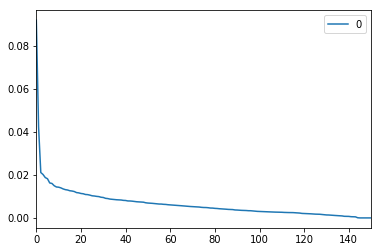

In [21]:
# try PCA to reduce dimensionality
pca = PCA(random_state=rs)
X_pca_train = pca.fit_transform(X_train)
var_ratio = pd.DataFrame(pca.explained_variance_ratio_)
var_ratio.plot()
print var_ratio[0:50].sum()

# choose a smaller number of pca vectors
pca = PCA(random_state=rs, n_components=50)
X_pca_train = pca.fit_transform(X_train)

In [22]:
# try lasso to drop some variables
lasso = LassoCV(cv=5, max_iter=2000, random_state=rs)
cross_val_disp(lasso, X_train=X_pca_train, y_train=y_train_log)
# PCA makes things worse. hahahaha - > probably cos we lose so much information 
# (only 67% of variance explained by 50 variables)

R^2 = -0.209 +/- 0.262


#### What happens if we vary the n-gram range for the job description column? 
(this was done with old dataset, numbers may not match up)

keeping max_features constant at 2000:
- **n-grams = 1-2**, best result is SVR with R^2 = 0.337 +/- 0.367
- **n-grams = 2-3**, best result is SVR with R^2 = 0.0618 +/- 0.542
- **n-grams = 1-3, best result is SVR with R^2 =  R^2 = 0.35 +/- 0.353**

#### What happens if we vary number of max features tf-idf vectorizer generates for the job description column?
keeping n-grams constant at 1-3, vary max_features:
- 500: best result is SVR with R^2 = 0.314 +/- 0.421
- **1000: best result is SVR with R^2 = R^2 = 0.394 +/- 0.332**
- 1500: best result is SVR with R^2 = 0.382 +/- 0.31
- 2000: best result is SVR with R^2 = 0.334 +/- 0.357
- 3000: best result is SVR with R^2 = 0.298 +/- 0.38

Looks like the best result is obtained when max_features = 1000

### Conclusion
In general, prediction of salary is poor, probably due to the small sample size. Need to get more samples.

## QUESTION 2: Factors that distinguish job category
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

#### Chosen question:
Based on a job posting, can i classify the various categories of data-related jobs?

In [25]:
q2 = q1.copy()

In [26]:
def tag_category(jobs):
    '''tag the job titles into categories'''
    tag = []
    for x in jobs:
        
        x = x.lower()
            
        if ('scientist' in x) or ('researcher' in x):
            ans = 'scientist'
            
        elif ('analyst') in x:
            ans = 'analyst'
        
        elif ('engineer' in x) or ('database' in x) or ('data base' in x) or ('technician' in x):
            ans = 'engineer'
        
        else: 
            ans = 'other'
        
        tag.append(ans)
    
    assert len(tag) == len(jobs.tolist())
    return tag

In [27]:
# class balance
q2['category'] = tag_category(q1.title)
q2.category.value_counts()

analyst      573
engineer     573
other        468
scientist    145
Name: category, dtype: int64

In [28]:
q2.head()

,company,link,location,title,description,salary_1,salary_2,salary_av,category
0,MSD,/rc/clk?jk=a29516b3a409d6f0&fccid=3c0bf511b4a2...,Singapore,Junior Data Scientist,Go to the main content section.MerckMenu\n ...,NaN,NaN,NaN,scientist
1,KPMG,/rc/clk?jk=6c88504cce66fb05&fccid=2dd390c3a48a...,Singapore,Data Scientist,?\n\nHomeSearch openingsSearch resultsCurren...,NaN,NaN,NaN,scientist
2,Pan Asia Resources,/company/Pan-Asia-Group/jobs/Data-Scientist-44...,Central Business District,Data Scientist,"Skip to Job Description, SearchClose\n\n\n\n\n...",5000.0,8500.0,6750.0,scientist
3,Procter & Gamble,/rc/clk?jk=a2875a11f184ce81&fccid=2da0dedf6df9...,Singapore,Research & Development - Research Scientist – ...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN,scientist
4,Procter & Gamble,/rc/clk?jk=7e3d4757a9102b27&fccid=2da0dedf6df9...,Singapore,Information Technology - Senior Data Scientist...,Go to the main content section.Procter & Gambl...,NaN,NaN,NaN,scientist


### Clean up descriptors

In [29]:
def clean_desc(blurb):
    '''cleans up descriptors'''
    blurb = blurb.lower().split('\n\n')
    desc = ''
    for text in blurb:
        if ('skill' in text) or ('experience' in text) or ('perform' in text) or ('qual' in text) or ('education' in text) or \
        ('develop' in text) or ('requirement' in text) or ('evaluat' in text):
            desc += text +'\n\n'
    return desc

In [30]:
q2['clean_desc'] = q2['description'].map(clean_desc)

In [71]:
# extract the features from the job descriptions
vec = CountVectorizer(stop_words='english', ngram_range= (1,3), max_features=1000)
vec.fit(q2.clean_desc)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [72]:
# set up the matrices
X = pd.DataFrame(vec.transform(q2.clean_desc).todense(), columns=vec.get_feature_names())
y = q2.category

# standardise X
ss = StandardScaler()
Xs = ss.fit_transform(X)

### Build Models

In [73]:
# calculate baseline accuracy
base_acc = y.value_counts().max()/ float(len(y))
print 'Baseline Accuracy: {:0.4}'.format(base_acc)

Baseline Accuracy: 0.3258


In [74]:
def cross_val_acc(est, X=Xs, y=y, cv=5):
    '''calculate cross_val_score and print result'''
    results = cross_val_score(est, X, y, cv=cv)
    # print results
    print 'Accuracy = {:0.3} +/- {:0.3}'.format(results.mean(), results.std())
rs = 4
njobs= 3

In [75]:
# baseline logistic regression
logreg = LogisticRegression(random_state=rs)
cross_val_acc(logreg)

Accuracy = 0.443 +/- 0.0862


In [76]:
# try to use logisitic regression with balanced class weights
logreg = LogisticRegression(random_state=rs, class_weight='balanced')
cross_val_acc(logreg)

Accuracy = 0.441 +/- 0.085


In [77]:
# add some lasso regularisation
logregcv = LogisticRegressionCV(cv=5, Cs=10, penalty='l1', solver='liblinear', random_state=rs, verbose=1, n_jobs=njobs)
logregcv.fit(Xs, y)

c = logregcv.C_.mean()

lasso_logreg = LogisticRegression(random_state=rs, penalty='l1', C=c)
cross_val_acc(lasso_logreg)

[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed: 44.2min finished


Accuracy = 0.471 +/- 0.138


In [78]:
# KNN
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 20, 2), 
             'weights': ['uniform', 'distance']}
knn_search = GridSearchCV(knn, knn_params, n_jobs=njobs, cv=5, verbose=1)
knn_search.fit(Xs, y)

print knn_search.best_params_
knn_best = knn_search.best_estimator_
cross_val_acc(knn_best)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  3.1min finished


{'n_neighbors': 1, 'weights': 'uniform'}
Accuracy = 0.384 +/- 0.0277


In [79]:
# decision tree classifier
dtreec = DecisionTreeClassifier(random_state=rs)
cross_val_acc(dtreec)

Accuracy = 0.447 +/- 0.0928


In [80]:
# random forest classifier
rfc = RandomForestClassifier(random_state=rs, n_estimators=100)
cross_val_acc(rfc)

Accuracy = 0.512 +/- 0.148


In [81]:
# SVC
svc = SVC(random_state=rs)
svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
             'C': np.logspace(0, 5, 5)}
svc_search = GridSearchCV(svc, svc_params, n_jobs=njobs, cv=5, verbose=1)
svc_search.fit(Xs, y)

print svc_search.best_params_
svc_best = svc_search.best_estimator_
cross_val_acc(svc_best)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  4.1min finished


{'kernel': 'rbf', 'C': 1.0}
Accuracy = 0.475 +/- 0.13


In [82]:
# naive bayes - try multinomial 
mnb = MultinomialNB()
cross_val_acc(mnb, X=X)

Accuracy = 0.434 +/- 0.0978


In [83]:
# random forest is best model. try to find out what features best distinguish between categories
rfc.fit(Xs, y)
impt = pd.DataFrame({'feature importances': rfc.feature_importances_, 
              'features': X.columns})
impt.sort_values('feature importances', ascending=False).head(20)

,feature importances,features
43,0.023810,analyst
799,0.013631,scientist
288,0.011045,engineer
447,0.008618,intelligence
518,0.008338,machine learning
316,0.007961,excel
517,0.007567,machine
102,0.007473,business
199,0.007263,data
290,0.006339,engineering


In [84]:
# do train test split and see confusion matrix and classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

rfc = RandomForestClassifier(random_state=rs, n_estimators=100)
rfc.fit(Xs_train, y_train)
y_pred = rfc.predict(Xs_test)
print confusion_matrix(y_test, y_pred)
print classification_report(y_test, y_pred)

[[111  40   9   2]
 [ 30 120  22   4]
 [ 40  59  48   5]
 [  3   8   2  25]]
             precision    recall  f1-score   support

    analyst       0.60      0.69      0.64       162
   engineer       0.53      0.68      0.60       176
      other       0.59      0.32      0.41       152
  scientist       0.69      0.66      0.68        38

avg / total       0.58      0.58      0.56       528



In [85]:
# recall isn't great because classes are not balanced. try to balance it
os = RandomOverSampler(random_state=rs)
Xs_train_os, y_train_os = os.fit_sample(Xs_train, y_train)
print 'oversampled class distribution of training set:'
print pd.Series(y_train_os).value_counts()

rfc = RandomForestClassifier(random_state=rs, n_estimators=100)
rfc.fit(Xs_train_os, y_train_os)
y_pred = rfc.predict(Xs_test)
print '\nconfusion matrix:'
print confusion_matrix(y_test, y_pred)
print '\nclassification report:'
print classification_report(y_test, y_pred)
print '\nwe sacrifice recall of majority class to get better recall of minority class'

oversampled class distribution of training set:
other        411
analyst      411
engineer     411
scientist    411
dtype: int64

confusion matrix:
[[ 99  38  21   4]
 [ 29 117  25   5]
 [ 28  56  62   6]
 [  4   6   2  26]]

classification report:
             precision    recall  f1-score   support

    analyst       0.62      0.61      0.61       162
   engineer       0.54      0.66      0.60       176
      other       0.56      0.41      0.47       152
  scientist       0.63      0.68      0.66        38

avg / total       0.58      0.58      0.57       528


we sacrifice recall of majority class to get better recall of minority class
